# One-sample feedforwardness testing: data

In [1]:
from pkg.utils import set_warnings

import datetime
import time
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

from graspologic.models import DCEREstimator, EREstimator
from graspologic.plot import heatmap
from graspologic.simulations import sample_edges, sbm
from graspologic.utils import (
    binarize,
    is_fully_connected,
    largest_connected_component,
    remove_loops,
)
from pkg.data import load_maggot_graph
from pkg.flow import calculate_p_upper, rank_graph_match_flow
from pkg.io import savefig
from pkg.plot import set_theme

In [2]:
# ## Preliminaries

In [3]:
set_warnings()

np.random.seed(8888)

t0 = time.time()

os.chdir("/Users/bpedigo/JHU_code/maggot")
out_path = Path("maggot_connectome/results/outputs/feedforwardness_data")


def stashfig(name, **kwargs):
    foldername = "feedforwardness_data"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
set_theme()

### Load the data

In [4]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]

## Run a one-sample test for feedforwardness on each edge type
Here the number of bootstrap samples for the null distributions is 100. We compute the
null distribution for both the ER and DCER fits to each observed network.

NB: There was some weirdness where often some of the sampled graphs were disconnected.
I think this happened in particular for the DCER graphs.

In [5]:


def p_upper_tstat(A):
    perm_inds = rank_graph_match_flow(A, n_init=1, max_iter=20)
    p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])
    return p_upper


def sample_null_distribution(p_mat, tstat_func, n_samples=1000, parallel=True):
    if parallel:

        def sample_and_tstat(seed=None):
            if seed is not None:
                np.random.seed(seed)
            A = sample_edges(np.array(p_mat), directed=True, loops=False)
            if not is_fully_connected(A):
                print("Original sample was not fully connected, trying again...")
                tries = 0
                connected = False
                while not connected and tries < 10:
                    A = sample_edges(np.array(p_mat), directed=True, loops=False)
                    connected = is_fully_connected(A)
                    tries += 1
                if not connected:
                    print("Did not sample connected graph after 10 tries.")
            tstat = tstat_func(A)
            return tstat

        seeds = np.random.randint(1e8, size=n_samples)
        null = Parallel(n_jobs=-2, verbose=10)(
            delayed(sample_and_tstat)(seed) for seed in seeds
        )
    else:
        null = []
        for i in tqdm(range(n_samples)):
            A = sample_edges(p_mat, directed=True, loops=False)
            if not is_fully_connected(A):
                print("Original sample was not fully connected, trying again...")
                tries = 0
                connected = False
                while not connected and tries < 10:
                    A = sample_edges(np.array(p_mat), directed=True, loops=False)
                    connected = is_fully_connected(A)
                    tries += 1
                if not connected:
                    print("Did not sample connected graph after 10 tries.")
            tstat = tstat_func(A)
            null.append(tstat)
    null = np.array(null)
    null = np.sort(null)
    return null


def compute_pvalues(p_upper, null):
    row = {}
    row["estimated_p_upper"] = p_upper
    ind = np.searchsorted(null, p_upper)
    row["pvalue"] = 1 - ind / len(
        null
    )  # TODO make more exact but this is roughly right for one sided
    return row


edge_types = ["ad", "aa", "dd", "da"]
null_estimators = {
    "ER": EREstimator(directed=True, loops=False),
    "DCER": DCEREstimator(directed=True, loops=False, degree_directed=False),
}

rerun_test = False

if rerun_test:
    currtime = time.time()

    n_null_samples = 100
    statistics = []

    for edge_type in edge_types:
        print(f"Edge type = {edge_type}")
        edge_type_adj = mg.to_edge_type_graph(edge_type).adj
        edge_type_adj = binarize(edge_type_adj)
        largest_connected_component(edge_type_adj)
        tstat = p_upper_tstat(edge_type_adj)

        observed = pd.DataFrame(index=[0])
        observed["estimated_p_upper"] = tstat
        observed["edge_type"] = edge_type
        observed["null_model"] = "Observed"
        statistics.append(observed)

        # estimate null distribution via bootstrap sampling
        for null_name, NullEstimator in null_estimators.items():
            ne = NullEstimator.fit(edge_type_adj)

            def sampler():
                return np.squeeze(ne.sample())

            null = sample_null_distribution(
                ne.p_mat_, p_upper_tstat, n_samples=n_null_samples
            )

            null_dist = pd.Series(data=null, name="estimated_p_upper").to_frame()
            null_dist["null_model"] = null_name
            null_dist["edge_type"] = edge_type
            statistics.append(null_dist)

            statistics_save = pd.concat(statistics, ignore_index=True)
            statistics_save.to_csv(out_path / "statistics.csv")
            print("Saved progress to statistics.csv")
            print()

    print(f"{time.time() - currtime:.3f} seconds elapsed.")

## Plot feedforward test statistics
We look at the test statistic $p_{upper}$ (see {doc}`./bilateral_symmetry`)
for the observed data as well as for samples from ER and DCER null models.

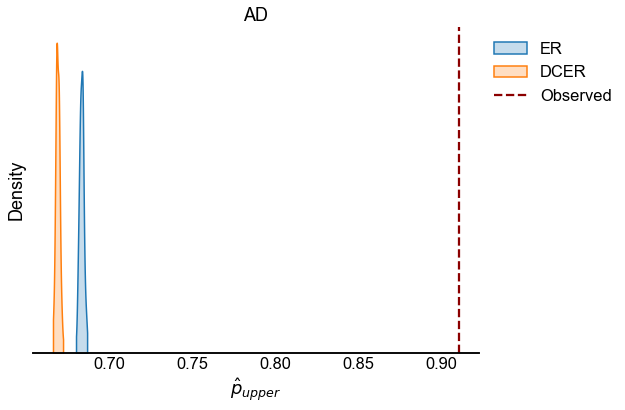

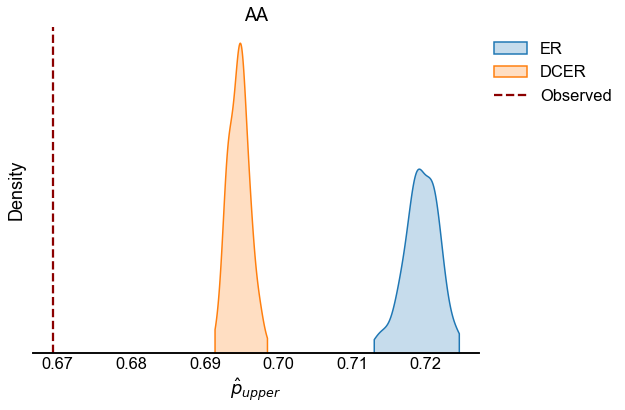

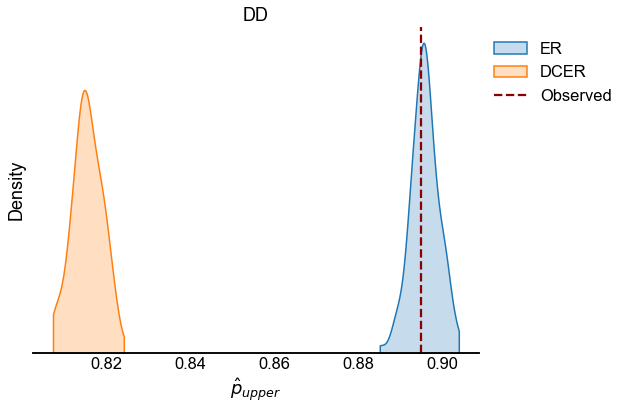

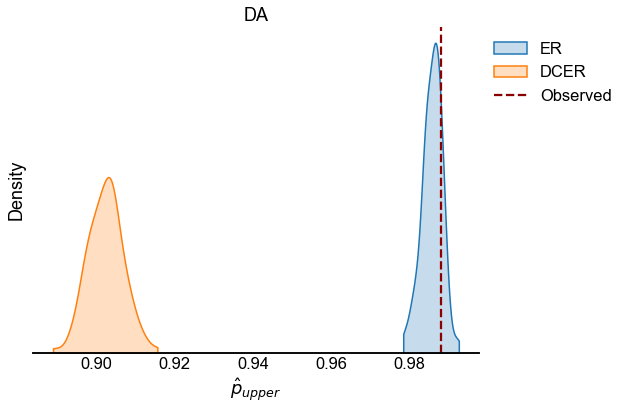

In [6]:

statistics = pd.read_csv(out_path / "statistics.csv", index_col=0)

for edge_type in edge_types:
    edge_type_stats = statistics[statistics["edge_type"] == edge_type]
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.kdeplot(
        data=edge_type_stats[edge_type_stats["null_model"] != "Observed"],
        x="estimated_p_upper",
        hue="null_model",
        ax=ax,
        cut=0,
        fill=True,
    )
    observed = edge_type_stats[edge_type_stats["null_model"] == "Observed"]
    line = ax.axvline(
        observed.iloc[0]["estimated_p_upper"], color="darkred", linestyle="--"
    )

    legend = ax.get_legend()
    legend.set_title("Null model")
    legend._set_loc((1, 0.8))
    handles = legend.legendHandles
    handles.append(line)
    labels = [t.get_text() for t in legend.texts]
    labels.append("Observed")
    legend.remove()
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1, 1), loc="upper left")

    ax.set(xlabel=r"$\hat{p}_{upper}$", title=edge_type.upper(), yticklabels=[])
    ax.spines["left"].set_visible(False)
    stashfig(f"{edge_type}_p_upper_statistic")

## End

In [7]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:00:10.756737
Completed at 2021-03-26 16:37:34.721658
----
